# Week 10 - Clustering: Part 1

In [1]:
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances

import matplotlib.pyplot as plt

## First Dataset: Acute Kidney

In [3]:
# 1) Load data
url = "https://raw.githubusercontent.com/muathdb/Week4/main/Acute%20Kidney.csv"
df = pd.read_csv(url)

# Basic cleaning: normalize column names
df.columns = (df.columns.astype(str)
              .str.strip()
              .str.replace(r"\s+", "_", regex=True)
              .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
              .str.lower())

In [4]:
target_col = 'aki'  # change if needed
if target_col in df.columns:
    X = df.drop(columns=[target_col])
else:
    X = df.copy()

# Keep only numeric features for K-means
X = X.select_dtypes(include=[np.number]).dropna()

print("Shape of numeric feature matrix:", X.shape)
X.head()

Shape of numeric feature matrix: (1185, 54)


,age,bmi,weight,t,p,r,bp,vent_firstday,vaso_firstday,chf,...,ph,cl,na,k,bicarbonate,scr,bun,po2,pco2,lactate
0,76,30.2,96.8,37.0,112.0,17.0,76.0,1,1,1,...,7.35,114.0,138,4.4,13.0,2.4,41,20.0,40.0,4.3
5,66,19.6,56.7,36.5,121.0,25.0,80.0,1,0,0,...,7.27,110.0,142,4.2,26.0,0.6,13,141.0,55.0,1.1
6,85,34.8,110.0,37.1,82.0,13.0,68.0,1,1,0,...,7.35,95.0,129,5.3,24.0,2.2,36,277.0,46.0,2.8
8,62,32.6,112.0,36.1,63.0,18.0,73.0,0,0,1,...,7.38,106.0,139,5.0,22.0,1.0,33,78.0,38.0,2.3
24,85,19.8,70.0,36.1,92.0,14.0,89.0,1,1,0,...,7.20,119.0,143,5.1,13.0,1.6,30,399.0,38.0,7.9


Numeric X shape after dropna: (1185, 54)


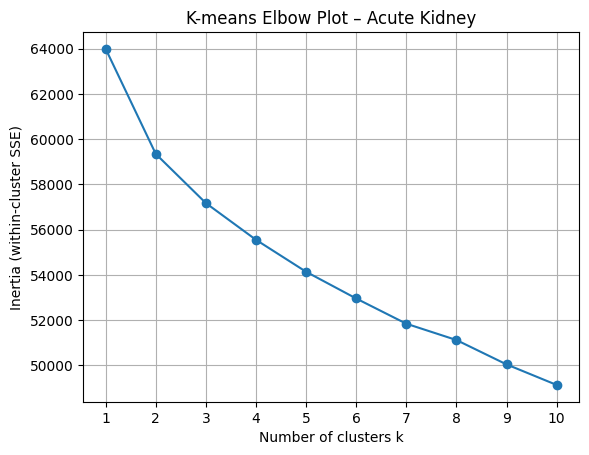

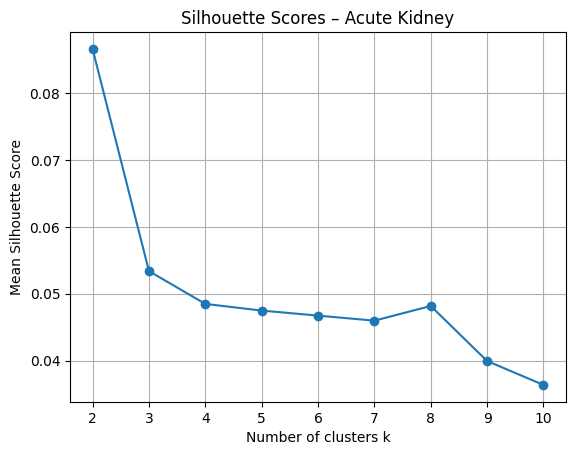

Best k by silhouette score: 2 with score = 0.0866451062063561
Length of cluster_labels: 1185
Length of df_km: 1185

Cluster counts in df_km:
cluster
0    775
1    410
Name: count, dtype: int64

First few rows with cluster labels (df_km):
   gender  age   race   unit   bmi  weight     t      p     r    bp  ...  \
0       M   76  white   MICU  30.2    96.8  37.0  112.0  17.0  76.0  ...   
5       F   66  white    CCU  19.6    56.7  36.5  121.0  25.0  80.0  ...   
6       M   85  other    CCU  34.8   110.0  37.1   82.0  13.0  68.0  ...   
8       M   62  white   SICU  32.6   112.0  36.1   63.0  18.0  73.0  ...   
24      M   85  white  TSICU  19.8    70.0  36.1   92.0  14.0  89.0  ...   

       cl   na    k  bicarbonate  scr  bun    po2  pco2  lactate  cluster  
0   114.0  138  4.4         13.0  2.4   41   20.0  40.0      4.3        1  
5   110.0  142  4.2         26.0  0.6   13  141.0  55.0      1.1        0  
6    95.0  129  5.3         24.0  2.2   36  277.0  46.0      2.8        0  
8

In [ ]:
# If you have a label column (e.g., aki outcome), put its name here:
target_col = "aki"   

if target_col in df.columns:
    X = df.drop(columns=[target_col])
else:
    X = df.copy()

# Keep only numeric columns and drop rows with missing values
X = X.select_dtypes(include=[np.number]).dropna()
print("Numeric X shape after dropna:", X.shape)

# Keep a copy of the rows used in clustering
df_km = df.loc[X.index].copy()

# =========================
# 2. FEATURE SCALING
# =========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =========================
# 3. ELBOW METHOD (INERTIA)
# =========================
k_values = range(1, 11)
inertias = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("K-means Elbow Plot – Acute Kidney")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# =========================
# 4. SILHOUETTE SCORES
# =========================
k_values_sil = range(2, 11)
sil_scores = []

for k in k_values_sil:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.figure()
plt.plot(k_values_sil, sil_scores, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Mean Silhouette Score")
plt.title("Silhouette Scores – Acute Kidney")
plt.xticks(k_values_sil)
plt.grid(True)
plt.show()

best_k = k_values_sil[int(np.argmax(sil_scores))]
print("Best k by silhouette score:", best_k, "with score =", max(sil_scores))

# =========================
# 5. FINAL K-MEANS MODEL
# =========================
final_k = best_k   # or set manually, e.g. final_k = 3

kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

print("Length of cluster_labels:", len(cluster_labels))
print("Length of df_km:", len(df_km))

# Attach clusters ONLY to the filtered df_km (no length mismatch)
df_km["cluster"] = cluster_labels

print("\nCluster counts in df_km:")
print(df_km["cluster"].value_counts().sort_index())

# =========================
# 6. (OPTIONAL) PUT CLUSTERS BACK ON FULL DF
# =========================
df["cluster"] = np.nan
df.loc[df_km.index, "cluster"] = cluster_labels

print("\nFirst few rows with cluster labels (df_km):")
print(df_km.head())

## Second Dataset: Colorectal cancer

In [12]:
# 1) Load and sample
URL = "https://raw.githubusercontent.com/muathdb/Week4/main/colorectal_cancer_dataset.csv"
df = pd.read_csv(URL)

df.columns = (
    pd.Index(df.columns)
    .astype(str).str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    .str.lower()
)
print(f"Rows: {len(df):,}  |  Columns: {df.shape[1]}")

Rows: 167,497  |  Columns: 28


After numeric filtering + dropna: (167497, 6)


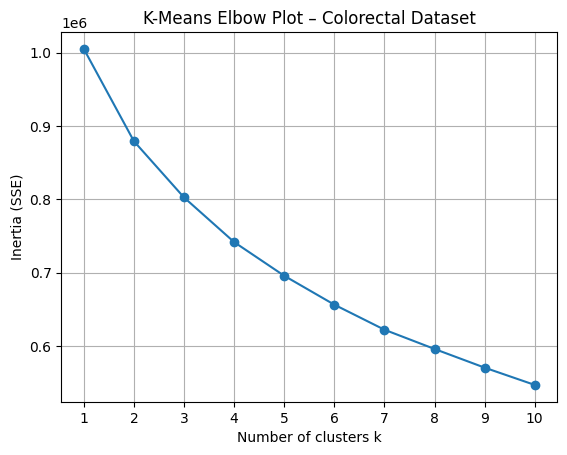

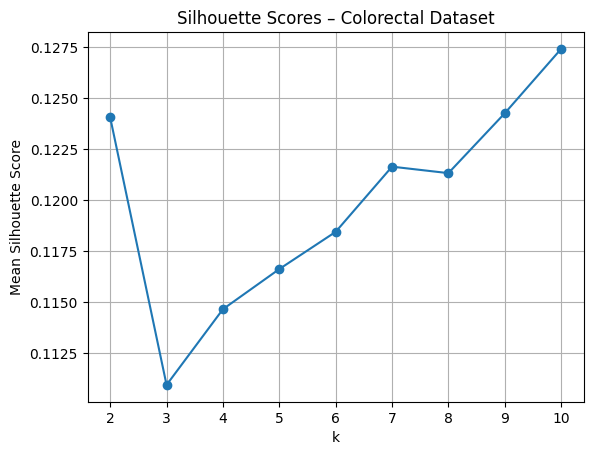


➡ Best k by silhouette: 10 | score = 0.12742562436997584
cluster_labels length = 167497
df_km length          = 167497

Cluster counts:
cluster
0    17962
1    17127
2    15786
3    15842
4    15612
5    17421
6    15885
7    17090
8    17106
9    17666
Name: count, dtype: int64

First few clustered rows:
   patient_id country  age gender cancer_stage  tumor_size_mm family_history  \
0           1      UK   77      M    Localized             69             No   
1           2      UK   59      M    Localized             33             No   
2           3   Japan   66      M     Regional             17             No   
3           4     USA   83      M     Regional             14             No   
4           5  France   66      M    Localized             34             No   

  smoking_history alcohol_consumption obesity_bmi  ... mortality  \
0              No                 Yes  Overweight  ...        No   
1              No                  No  Overweight  ...        No   
2      

In [13]:
# If your dataset has a true label column, put its name here
# (Examples: survival_5yr, cancer_stage, outcome, etc.)
target_col = "survival_5_years"     

if target_col in df.columns:
    X = df.drop(columns=[target_col])
else:
    X = df.copy()

# Keep numeric columns and drop missing rows
X = X.select_dtypes(include=[np.number]).dropna()
print("After numeric filtering + dropna:", X.shape)

# Store only the rows used in clustering
df_km = df.loc[X.index].copy()

# ======================================================
# 2️⃣ FEATURE SCALING
# ======================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ======================================================
# 3️⃣ ELBOW METHOD
# ======================================================
k_values = range(1, 11)
inertias = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia (SSE)")
plt.title("K-Means Elbow Plot – Colorectal Dataset")
plt.xticks(k_values)
plt.grid()
plt.show()

# ======================================================
# 4️⃣ SILHOUETTE SCORES
# ======================================================
k_values_sil = range(2, 11)
sil_scores = []

for k in k_values_sil:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure()
plt.plot(k_values_sil, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Mean Silhouette Score")
plt.title("Silhouette Scores – Colorectal Dataset")
plt.xticks(k_values_sil)
plt.grid()
plt.show()

best_k = k_values_sil[int(np.argmax(sil_scores))]
print("\n➡ Best k by silhouette:", best_k, "| score =", max(sil_scores))

# ======================================================
# 5️⃣ FIT FINAL CLUSTER MODEL
# ======================================================
final_k = best_k     # <-- OR manually set: e.g. final_k = 3

kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

print("cluster_labels length =", len(cluster_labels))
print("df_km length          =", len(df_km))

# Attach clusters to filtered DataFrame
df_km["cluster"] = cluster_labels

print("\nCluster counts:")
print(df_km["cluster"].value_counts().sort_index())

# ======================================================
# 6️⃣ ADD CLUSTERS BACK TO FULL DF
# ======================================================
df["cluster"] = np.nan
df.loc[df_km.index, "cluster"] = cluster_labels

print("\nFirst few clustered rows:")
print(df_km.head())

## Third Dataset: Diabetes

In [3]:
# 1) Load Dataset
URL = "https://raw.githubusercontent.com/muathdb/Week4/main/diabetes_012_health_indicators_BRFSS2015.csv"
df = pd.read_csv(URL)

df.columns = (
    pd.Index(df.columns)
    .astype(str).str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    .str.lower()
)
print(f"Rows: {len(df):,}  |  Columns: {df.shape[1]}")

Rows: 253,680  |  Columns: 22


Shape after numeric filtering + dropna: (253680, 21)
Using 20000 rows for elbow & silhouette diagnostics


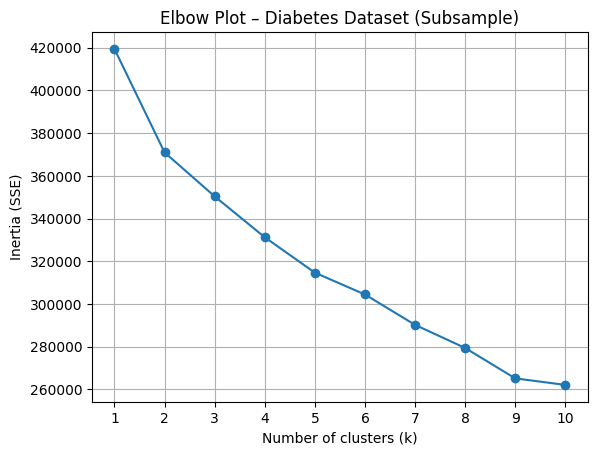

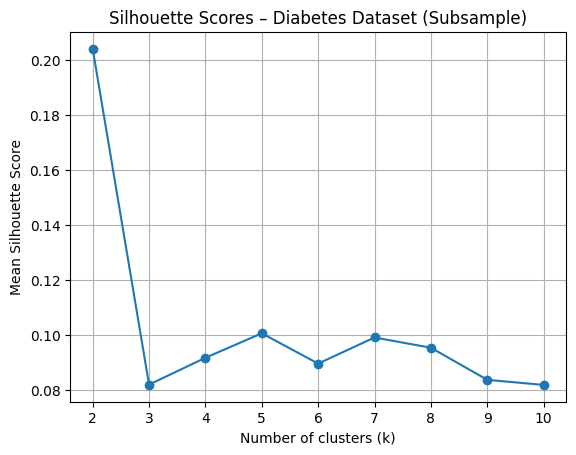


➡ Best k by silhouette (subsample): 2 | score = 0.2040696632492638
Full-data cluster labels generated: 253680

Cluster counts: cluster
0     80272
1    173408
Name: count, dtype: int64

First few clustered rows:
   diabetes_012  highbp  highchol  cholcheck   bmi  smoker  stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   heartdiseaseorattack  physactivity  fruits  ...  nodocbccost  genhlth  \
0                   0.0           0.0     0.0  ...          0.0      5.0   
1                   0.0           1.0     0.0  ...          1.0      3.0   
2                   0.0           0.0     1.0  ...          1.0      5.0   
3                   0.0           1.0     1.0  ...          0.

In [6]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Target column (drop it for clustering)
target_col = "diabetes_012"   

if target_col in df.columns:
    X = df.drop(columns=[target_col])
else:
    X = df.copy()

# Keep numeric; drop rows missing numeric values
X = X.select_dtypes(include=[np.number]).dropna()
print("Shape after numeric filtering + dropna:", X.shape)

# Keep only rows used for clustering
df_km = df.loc[X.index].copy()

# ======================================================
# 2️⃣ SUBSAMPLING (FOR SPEED) 
# ======================================================
n_sample = 20000   # lower if needed for speed (e.g., 10000)
if len(X) > n_sample:
    X_small = X.sample(n=n_sample, random_state=42)
else:
    X_small = X.copy()

print("Using", len(X_small), "rows for elbow & silhouette diagnostics")

# ======================================================
# 3️⃣ SCALE FEATURES
# ======================================================
scaler = StandardScaler()
X_scaled_full = scaler.fit_transform(X)
X_scaled_small = scaler.transform(X_small)

# ======================================================
# 4️⃣ ELBOW METHOD (ON SUBSAMPLE)
# ======================================================
k_values = range(1, 11)
inertias = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=200)
    km.fit(X_scaled_small)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Plot – Diabetes Dataset (Subsample)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

# ======================================================
# 5️⃣ SILHOUETTE SCORES (ON SUBSAMPLE)
# ======================================================
k_values_sil = range(2, 11)
sil_scores = []

for k in k_values_sil:
    km = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=200)
    labels = km.fit_predict(X_scaled_small)
    score = silhouette_score(X_scaled_small, labels)
    sil_scores.append(score)

plt.figure()
plt.plot(k_values_sil, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Mean Silhouette Score")
plt.title("Silhouette Scores – Diabetes Dataset (Subsample)")
plt.xticks(k_values_sil)
plt.grid(True)
plt.show()

# pick best k
best_k = k_values_sil[int(np.argmax(sil_scores))]
print("\n➡ Best k by silhouette (subsample):", best_k, "| score =", max(sil_scores))

# ======================================================
# 6️⃣ FINAL CLUSTERING ON FULL DATA (MiniBatchKMeans)
# ======================================================
final_k = best_k  # or set manually

mbk = MiniBatchKMeans(
    n_clusters=final_k,
    random_state=42,
    batch_size=1024,
    n_init=5,
    max_iter=200
)

cluster_labels = mbk.fit_predict(X_scaled_full)
print("Full-data cluster labels generated:", len(cluster_labels))

# Attach clusters to filtered df
df_km["cluster"] = cluster_labels
print("\nCluster counts:", df_km["cluster"].value_counts().sort_index())

# ======================================================
# ➕ Add clusters back to full df
# ======================================================
df["cluster"] = np.nan
df.loc[df_km.index, "cluster"] = cluster_labels

print("\nFirst few clustered rows:")
print(df_km.head())

# ======================================================
# 7️⃣ CLUSTER PROFILES
# ======================================================
cluster_profile = df_km.groupby("cluster")[X.columns].mean()
print("\nCluster feature means (rounded):\n")
print(cluster_profile.round(2))